In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import sklearn
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
import yfinance as yf

In [ ]:
# Télécharger les données de GOOGL
data = yf.download("GOOGL", start="2007-01-01", end="2018-12-31", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2007-01-03,11.659185,11.885342,11.497609,11.619540,307951740
2007-01-04,12.049911,12.067116,11.678136,11.694344,315188496
2007-01-05,12.147904,12.155635,11.921498,12.030962,274609116
2007-01-08,12.057892,12.214731,12.023482,12.160373,189985824
2007-01-09,12.105765,12.174335,11.998546,12.104519,215040744


In [ ]:
data['Log_Return'] = np.log(data['Open'] / data['Open'].shift(1))

# Drop rows with NaN values (the first row will have NaN for returns)
df = data.dropna()

print(df[['Open', 'Log_Return']].head())

Price            Open Log_Return
Ticker          GOOGL           
Date                            
2007-01-04  11.694344   0.006417
2007-01-05  12.030962   0.028378
2007-01-08  12.160373   0.010699
2007-01-09  12.104519  -0.004604
2007-01-10  12.079086  -0.002103


From now we are going to work with the dataset df and his variable Log_Return

3018

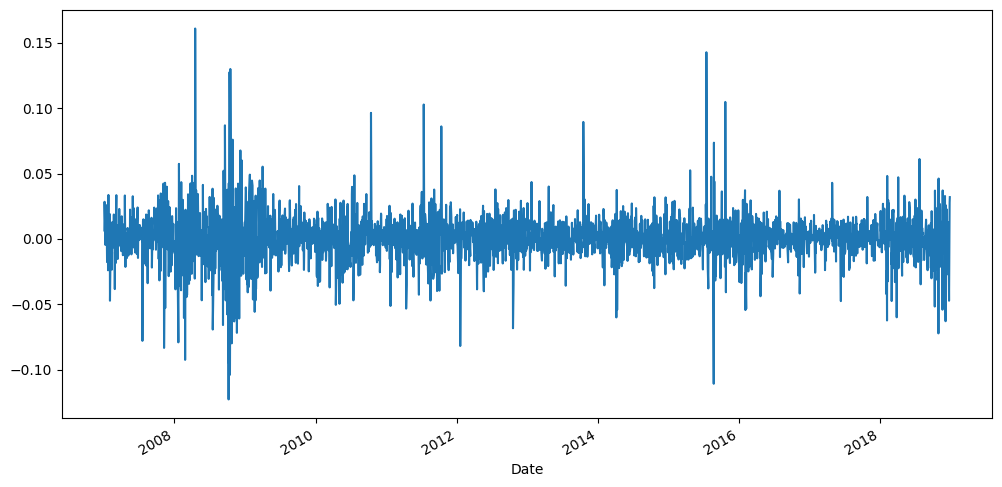

In [ ]:
df['Log_Return'].plot(figsize=(12,6))
len(df)

<Axes: xlabel='Date'>

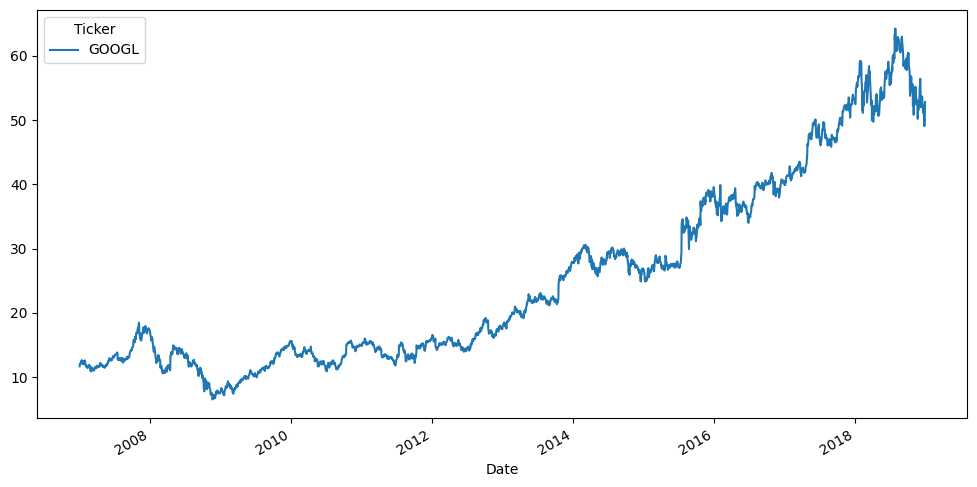

In [ ]:
df['Open'].plot(figsize=(12,6))

In [ ]:
df_rl = df['Log_Return'].astype(float)
print(df_rl) ## Ensure float object

Date
2007-01-04    0.006417
2007-01-05    0.028378
2007-01-08    0.010699
2007-01-09   -0.004604
2007-01-10   -0.002103
                ...   
2018-12-21    0.005870
2018-12-24   -0.047342
2018-12-26    0.013792
2018-12-27    0.027875
2018-12-28    0.031934
Name: Log_Return, Length: 3018, dtype: float64


In [ ]:
#splitting train/test data
from sklearn.preprocessing import MinMaxScaler
train_data_size = round(0.884*len(df_rl)) ## Ensure to predict the last year 2018
train_data = df_rl[ : train_data_size ]
test_data = df_rl[train_data_size:]
print(len(train_data))
print(len(test_data))

2668
350


Here we will Data Process our data, to be use in our deep model.

In [ ]:
train_data_np = train_data.values
test_data_np = test_data.values

In [ ]:
#Standardising features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler2 = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data_np.reshape(-1, 1))
test_data_normalized = scaler2.fit_transform(test_data_np.reshape(-1, 1))

In [ ]:
### Transform our data as a Tensor
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

In [ ]:
## Sliding windows approach (function which creates sequences)
train_window = 100
device = "cuda" if torch.cuda.is_available() else "cpu"
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
#sequences creation to train our models
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
test_inout_seq = create_inout_sequences(test_data_normalized, train_window)

(tensor([-0.0588, -0.1666, -0.1490,  0.0491, -0.0666, -0.0566, -0.1922, -0.2594,
         -0.2280, -0.0692, -0.3037, -0.0808,  0.1025, -0.2773, -0.0335, -0.1910,
         -0.0988, -0.0005, -0.4677, -0.2092, -0.2743, -0.0486, -0.2205, -0.0802,
         -0.3000, -0.1576, -0.1212, -0.0429, -0.1827, -0.0484, -0.1136, -0.0027,
         -0.1776, -0.1776, -0.4050, -0.2056, -0.2563, -0.0955, -0.2634,  0.0323,
          0.1015, -0.1872, -0.1529, -0.2182, -0.1726, -0.2427, -0.0610, -0.1690,
         -0.1722, -0.0939, -0.1419,  0.0271, -0.0445, -0.1479, -0.0884, -0.1598,
         -0.0934, -0.1715, -0.2007, -0.0380, -0.0124, -0.1467, -0.1091, -0.2225,
         -0.1497, -0.1654, -0.0669, -0.1340, -0.0543, -0.1721, -0.0859,  0.0998,
         -0.2855, -0.1561, -0.1138, -0.1621, -0.1052, -0.1477, -0.2373, -0.1872,
         -0.1708, -0.0755, -0.1040, -0.2245, -0.1339, -0.1208, -0.2132, -0.0787,
         -0.1877, -0.1336,  0.0235, -0.1406, -0.1716, -0.0823, -0.0187, -0.2178,
         -0.0670, -0.0568, -

In [ ]:
#List creation for dataloaders
X_train_tensor = [item[0] for item in train_inout_seq]
y_train_tensor = [item[1] for item in train_inout_seq]

X_test_tensor = [item[0] for item in test_inout_seq]
y_test_tensor = [item[1] for item in test_inout_seq]


print(type(X_train_tensor))
print(len(X_train_tensor[0]))
print(len(X_test_tensor))

<class 'list'>
100
250


In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataloader_train = DataLoader(CustomDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True,drop_last=True)
dataloader_test = DataLoader(CustomDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=True,drop_last=True) # Windows independent

Create our model

In [ ]:
from torch import nn


class LSTMNetwork(nn.Module):
    def __init__(self, n_hidden, num_layer):
        super().__init__()
        self.lstm = nn.LSTM(input_size=train_window, hidden_size = n_hidden , num_layers= num_layer)
        self.linear = nn.Linear(n_hidden, 1) ## 1 output days

    def forward(self, x):
        x, (_,_) = self.lstm(x)
        y = self.linear(x)
        return y

In [ ]:
#train function to train model
def train_loop(dataloader, model, loss_fn, optimizer, device):

    model.train()
    loss_list=[]
    for X,y in dataloader:
        # Reset gradients
        optimizer.zero_grad()
        # Forward
        pred = model(X.to(device))
        loss = loss_fn(pred,y.to(device))
        # Backpropagation
        loss.backward()
        optimizer.step()
def eval_loop(dataloader, model, loss_fn, device):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0., 0.

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            loss += loss_fn(pred, y.to(device)).item()

    loss /= num_batches
    return loss

In [ ]:
# Cross validation
from sklearn.model_selection import KFold
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np


n_splits = 5 #5 blocks Cross validation
skf = KFold(n_splits=n_splits, shuffle=True, random_state=123)

# List of loss
cv_scores = []

epochs =10  #number of epochs to train each model
loss_model_fin=[]
param_list=[]

#parameters to test
list_n_hidden= [16, 32, 64, 128]
list_num_layer= [1,2,3]

loss_fn = nn.MSELoss()

for n_hidden in list_n_hidden:
    for num_layer in list_num_layer:
        loos_model=[]
        for train_index, test_index in skf.split(X_train_tensor):
            X_train, y_train = [], []
            X_val, y_val = [], []
            for elemn_train in train_index :
                X_train.append(X_train_tensor[elemn_train])
                y_train.append(y_train_tensor[elemn_train])
            for elem_test in test_index :
                 X_val.append(X_train_tensor[elem_test])
                 y_val.append( y_train_tensor[elem_test])
            dataloader_train = DataLoader(CustomDataset( X_train,  y_train), batch_size=32, shuffle=True,drop_last=True)
            dataloader_val = DataLoader(CustomDataset( X_val, y_val), batch_size=32, shuffle=True,drop_last=True)
            model = LSTMNetwork(n_hidden,num_layer).to(device) #creation du model à tester
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            ##Entrainement du modele
            for t in range(epochs):
                print(f"Epoch {t + 1}\n-------------------------------------------------")
            # Train loop
                train_loop(dataloader_train, model, loss_fn, optimizer, device)
            # Evaluation loop
                loss_train = eval_loop(dataloader_train, model, loss_fn, device)
                loss_val = eval_loop(dataloader_val, model, loss_fn, device)
                loos_model.append(loss_val)

        loss_model_fin.append(np.mean(loos_model))
        param_list.append( [n_hidden, num_layer])

Epoch 1
-------------------------------------------------
Epoch 2
-------------------------------------------------
Epoch 3
-------------------------------------------------
Epoch 4
-------------------------------------------------
Epoch 5
-------------------------------------------------
Epoch 6
-------------------------------------------------
Epoch 7
-------------------------------------------------
Epoch 8
-------------------------------------------------
Epoch 9
-------------------------------------------------
Epoch 10
-------------------------------------------------
Epoch 1
-------------------------------------------------
Epoch 2
-------------------------------------------------
Epoch 3
-------------------------------------------------
Epoch 4
-------------------------------------------------
Epoch 5
-------------------------------------------------
Epoch 6
-------------------------------------------------
Epoch 7
-------------------------------------------------
Epoch 8
-----

KeyboardInterrupt: 

In [ ]:
valeur_minimale = np.min(loss_model_fin)
indice_minimale = np.argmin(loss_model_fin)
param_opti = param_list[indice_minimale]
print(valeur_minimale, param_opti)

In [ ]:
#validation sample creation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.3, random_state=42)

In [ ]:
# Epochs numbers tuning

dataloader_trainepochs = DataLoader(CustomDataset(X_train, y_train), batch_size=32, shuffle=True,drop_last=True)
dataloader_valepochs = DataLoader(CustomDataset(X_val, y_val), batch_size=32, shuffle=True,drop_last=True)

model = LSTMNetwork(32,3).to(device) ## With our hyperparameters find above

epochs =300
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losslist_test= []
losslist_train=[]


for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------------------------")

    # Train loop
    train_loop(dataloader_trainepochs, model, loss_fn, optimizer, device)

    # Evaluation loop
    loss_train = eval_loop(dataloader_trainepochs, model, loss_fn, device)
    losslist_train.append(loss_train)

    print(f"Training set: Avg loss: {loss_train: >8f}")

    loss_test = eval_loop(dataloader_valepochs, model, loss_fn, device)
    losslist_test.append(loss_test)
    print(f"Val set:  Avg loss: {loss_test: >8f}\n")

print("Done!")

Epoch 1
-------------------------------------------------
Training set: Avg loss: 0.018386
Val set:  Avg loss: 0.018632

Epoch 2
-------------------------------------------------
Training set: Avg loss: 0.018015
Val set:  Avg loss: 0.018220

Epoch 3
-------------------------------------------------
Training set: Avg loss: 0.017425
Val set:  Avg loss: 0.017636

Epoch 4
-------------------------------------------------
Training set: Avg loss: 0.017227
Val set:  Avg loss: 0.017376

Epoch 5
-------------------------------------------------
Training set: Avg loss: 0.016947
Val set:  Avg loss: 0.017339

Epoch 6
-------------------------------------------------
Training set: Avg loss: 0.016837
Val set:  Avg loss: 0.017806

Epoch 7
-------------------------------------------------
Training set: Avg loss: 0.016671
Val set:  Avg loss: 0.017549

Epoch 8
-------------------------------------------------
Training set: Avg loss: 0.016501
Val set:  Avg loss: 0.017642

Epoch 9
------------------------

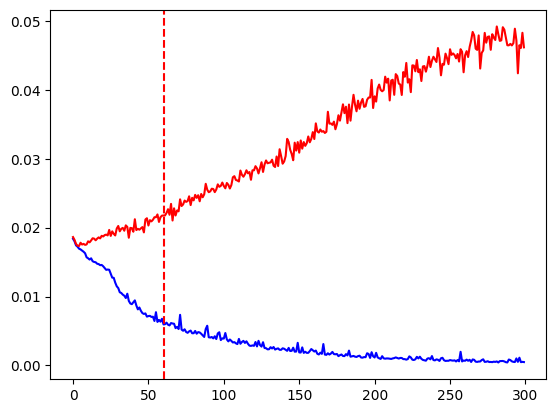

In [ ]:
#Loss versus epochs graphic
plt.plot([i for i in range(epochs)],losslist_train,color='blue')
plt.plot([i for i in range(epochs)],losslist_test,color='red')

plt.axvline(x=60 , color='red', linestyle='--', label='Vertical Line at x=25')

plt.show()

In [ ]:
#training the final model on the whole train set.
dataloader_train = DataLoader(CustomDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True,drop_last=True)
dataloader_test = DataLoader(CustomDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=True,drop_last=True)

model = LSTMNetwork(32,3).to(device)

epochs = 60
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------------------------")

    # Train loop
    train_loop(dataloader_train, model, loss_fn, optimizer, device)

    # Evaluation loop
    loss_train = eval_loop(dataloader_train, model, loss_fn, device)

    print(f"Training set: Avg loss: {loss_train: >8f}")

    loss_test = eval_loop(dataloader_test, model, loss_fn, device)
    print(f"Test set:  Avg loss: {loss_test: >8f}\n")

print("Done!")

Epoch 1
-------------------------------------------------
Training set: Avg loss: 0.017858
Test set:  Avg loss: 0.135741

Epoch 2
-------------------------------------------------
Training set: Avg loss: 0.017697
Test set:  Avg loss: 0.136992

Epoch 3
-------------------------------------------------
Training set: Avg loss: 0.017191
Test set:  Avg loss: 0.140121

Epoch 4
-------------------------------------------------
Training set: Avg loss: 0.017252
Test set:  Avg loss: 0.136604

Epoch 5
-------------------------------------------------
Training set: Avg loss: 0.017008
Test set:  Avg loss: 0.139007

Epoch 6
-------------------------------------------------
Training set: Avg loss: 0.016713
Test set:  Avg loss: 0.142150

Epoch 7
-------------------------------------------------
Training set: Avg loss: 0.016971
Test set:  Avg loss: 0.137078

Epoch 8
-------------------------------------------------
Training set: Avg loss: 0.016808
Test set:  Avg loss: 0.130959

Epoch 9
----------------

Predictions on train set

In [ ]:
#compute prediction on train set
pred_arr = []
y_arr = []
model.eval()
train_dataloader = DataLoader(CustomDataset(X_train_tensor, y_train_tensor), batch_size=8,drop_last=True)
with torch.no_grad():
    for batch , item in enumerate(train_dataloader):
        x , y = item
        x , y = x.to(device) , y.to(device)
        print(x)
        pred = model(x)
        pred = scaler.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
        y = scaler.inverse_transform(y.detach().cpu().numpy()).reshape(-1)
        pred_arr = pred_arr + list(pred)
        y_arr = y_arr + list(y)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
        [-1.8454e-02, -1.6140e-01, -3.8873e-02, -4.6460e-02, -5.9763e-02,
         -1.7518e-01, -1.4578e-01, -1.5733e-01, -1.0941e-01, -1.7934e-01,
          3.2039e-02, -1.7640e-01, -2.3282e-01, -4.0085e-02, -2.7616e-01,
         -7.3629e-02, -2.0315e-01, -2.7012e-01, -1.1297e-01,  1.9151e-02,
         -1.4540e-01, -1.3558e-03, -2.6097e-01, -1.7269e-01, -1.2294e-01,
         -7.5256e-02, -1.5406e-01, -1.2064e-01,  1.9577e-02, -7.2069e-02,
         -1.8889e-01, -3.6713e-01, -1.1665e-01, -2.6195e-01, -1.7072e-01,
         -1.2184e-01, -2.8514e-01, -4.9993e-02, -5.2960e-02, -3.7229e-01,
         -2.7615e-01, -3.4085e-02, -2.7501e-01,  6.8162e-03,  7.6202e-02,
         -1.1674e-01, -2.1641e-01, -1.2768e-01, -1.1221e-01, -3.2143e-02,
          7.2525e-02,  1.2798e-01, -2.6048e-01, -5.1804e-01, -3.1719e-01,
         -5.1140e-01, -8.0407e-02,  5.4806e-02, -2.8881e-01,  2.4578e-02,
         -7.0773e-02, -5.2802e-02,

In [ ]:
#function to compute rmse on the log return of the train set.
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics_train(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            pred = model(x)
            pred = scaler.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
            y = scaler.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
        return math.sqrt(mean_squared_error(y_arr,pred_arr))

In [ ]:
#function to compute rmse on the log return of the test set.
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics_test(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            pred = model(x)
            pred = scaler2.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
            y = scaler2.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
        return math.sqrt(mean_squared_error(y_arr,pred_arr))

In [ ]:
#Loss on train and test set
print(f"train mse loss {calculate_metrics_train(dataloader_train)}")
print(f"test mse loss {calculate_metrics_test(dataloader_test)}")

train mse loss 0.010831962959744854
test mse loss 0.03328899702268011


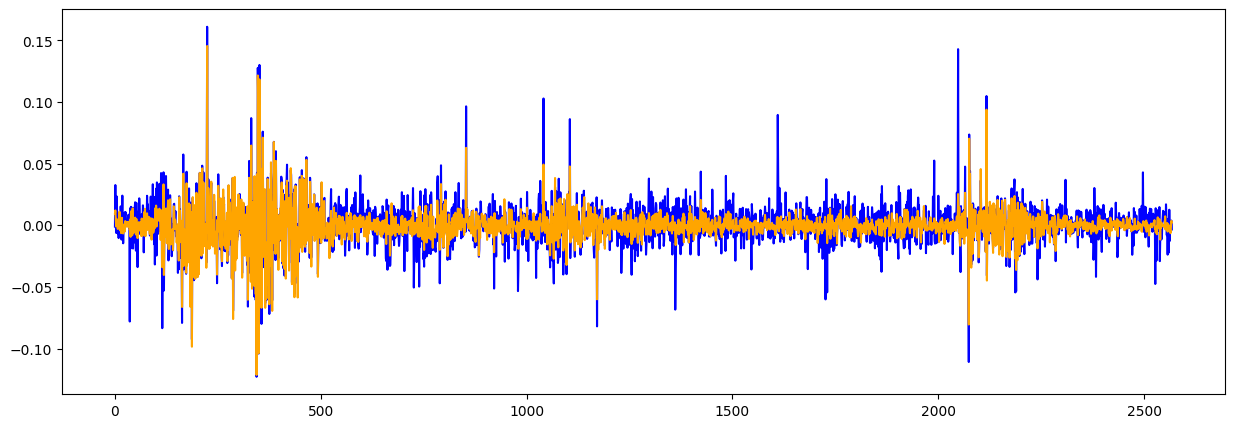

In [ ]:
# fitted train values
plt.plot([i for i in range(len(pred_arr))],y_arr,color='blue')
plt.plot([i for i in range(len(pred_arr))],pred_arr,color='orange')
plt.gcf().set_size_inches(15, 5)

plt.show()

Prediction on test set, using real values as input

In [ ]:
pred_arr_test = []
y_arr_test = []
dataloader_test = DataLoader(CustomDataset(X_test_tensor, y_test_tensor), batch_size=8,drop_last=True)
with torch.no_grad():
    for batch , item in enumerate(dataloader_test):
        x , y = item
        x , y = x.to(device) , y.to(device)
        pred = model(x)
        pred = scaler2.inverse_transform(pred.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
        y = scaler2.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
        pred_arr_test = pred_arr_test + list(pred)
        y_arr_test = y_arr_test + list(y)

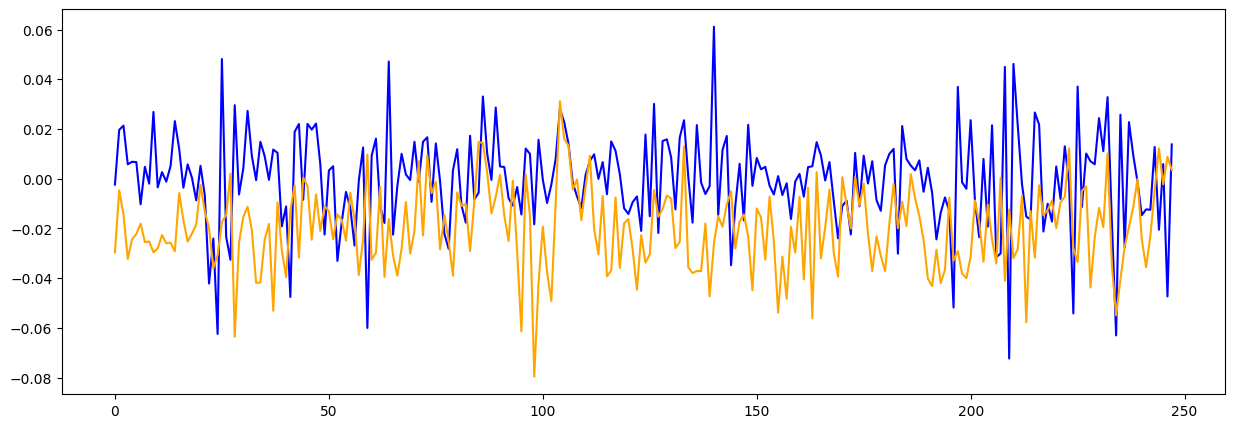

In [ ]:
#fitted values not using its own predictions but true values
plt.plot([i for i in range(len(pred_arr_test))],y_arr_test,color='blue')
plt.plot([i for i in range(len(pred_arr_test))],pred_arr_test,color='orange')
plt.gcf().set_size_inches(15, 5)
plt.show()

Prediction on test set, using previous prediction as input

In [ ]:
pred_list_test=[]
print(len(test_data))
pred_data_nump= test_data_normalized[0:train_window ]
print(len(pred_data_nump))
nbr_pred=365
for i in range(nbr_pred):
    pred_data_nump=np.append(pred_data_nump,0)
    pred_data= torch.FloatTensor(pred_data_nump).view(-1)
    pred_inout_seq = create_inout_sequences(pred_data, train_window )
    pred_tensor = [item[0] for item in pred_inout_seq]
    y_pred = [item[1] for item in pred_inout_seq]
    dataloader_pred = DataLoader(CustomDataset(pred_tensor,y_pred),batch_size=1)
    model.eval()
    with torch.no_grad():
        for i,j in dataloader_pred:
            pred= model(i.to(device))
            pred_data_nump= np.append(pred_data_nump[1:len(pred_data_nump)-1],pred.detach().cpu().numpy().reshape(1,-1))
            pred = scaler2.inverse_transform(pred.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_list_test= pred_list_test + list(pred)
print(len(pred_list_test))

In [ ]:
#Predicted values on test set using its own predictions for 365 values

plt.plot([i for i in range(len(pred_list_test))],pred_list_test,color='orange')
plt.plot([i for i in range(nbr_pred)],test_data[(train_window):(train_window+nbr_pred)],color='blue')

plt.gcf().set_size_inches(15, 5)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# RMSE
rmse = math.sqrt(mean_squared_error(pred_list_test, test_data[(train_window):(train_window+nbr_pred)]))

# MSE
mse = mean_squared_error(pred_list_test, test_data[(train_window):(train_window+nbr_pred)])

# MAE
mae = mean_absolute_error(pred_list_test, test_data[(train_window):(train_window+nbr_pred)])

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

In [ ]:
##compute fitted values on test set using its own predictions at each step
pred_list_test=[]
print(len(test_data))
pred_data_nump= test_data_normalized[0:train_window ]
print(len(pred_data_nump))
nbr_pred=5
for i in range(nbr_pred):
    pred_data_nump=np.append(pred_data_nump,0)
    pred_data= torch.FloatTensor(pred_data_nump).view(-1)
    pred_inout_seq = create_inout_sequences(pred_data, train_window )
    pred_tensor = [item[0] for item in pred_inout_seq]
    y_pred = [item[1] for item in pred_inout_seq]
    dataloader_pred = DataLoader(CustomDataset(pred_tensor,y_pred),batch_size=1)
    model.eval()
    with torch.no_grad():
        for i,j in dataloader_pred: #le dataloarder est de longueur 1
            pred= model(i.to(device))
            pred_data_nump= np.append(pred_data_nump[1:len(pred_data_nump)-1],pred.detach().cpu().numpy().reshape(1,-1))
            pred = scaler2.inverse_transform(pred.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_list_test= pred_list_test + list(pred)
print(len(pred_list_test))
pred_5_lstm_py = pred_list_test

In [ ]:
#Predicted values on test set using its own predictions for 5 values

plt.plot([i for i in range(len(pred_list_test))],pred_list_test,color='orange')
plt.plot([i for i in range(nbr_pred)],test_data[(train_window):(train_window+nbr_pred)],color='blue')

plt.gcf().set_size_inches(15, 5)
plt.show()

In [ ]:
# RMSE
rmse = math.sqrt(mean_squared_error(pred_list_test, test_data[(train_window):(train_window+nbr_pred)]))

# MSE
mse = mean_squared_error(pred_list_test, test_data[(train_window):(train_window+nbr_pred)])

# MAE
mae = mean_absolute_error(pred_list_test, test_data[(train_window):(train_window+nbr_pred)])

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

In [ ]:
##compute fitted values on test set using its own predictions at each step
pred_list_test=[]
print(len(test_data))
pred_data_nump= test_data_normalized[0:train_window ]
print(len(pred_data_nump))
nbr_pred=22
for i in range(nbr_pred):
    pred_data_nump=np.append(pred_data_nump,0)
    pred_data= torch.FloatTensor(pred_data_nump).view(-1)
    pred_inout_seq = create_inout_sequences(pred_data, train_window )
    pred_tensor = [item[0] for item in pred_inout_seq]
    y_pred = [item[1] for item in pred_inout_seq]
    dataloader_pred = DataLoader(CustomDataset(pred_tensor,y_pred),batch_size=1)
    model.eval()
    with torch.no_grad():
        for i,j in dataloader_pred: #le dataloarder est de longueur 1
            pred= model(i.to(device))
            pred_data_nump= np.append(pred_data_nump[1:len(pred_data_nump)-1],pred.detach().cpu().numpy().reshape(1,-1))
            pred = scaler2.inverse_transform(pred.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_list_test= pred_list_test + list(pred)
print(len(pred_list_test))
pred_22_lstm_py = pred_list_test

In [ ]:
#Predicted values on test set using its own predictions for 22 values

plt.plot([i for i in range(len(pred_list_test))],pred_list_test,color='orange')
plt.plot([i for i in range(nbr_pred)],test_data[(train_window):(train_window+nbr_pred)],color='blue')

plt.gcf().set_size_inches(15, 5)
plt.show()

In [ ]:
# RMSE
rmse = math.sqrt(mean_squared_error(pred_list_test, test_data[(train_window):(train_window+nbr_pred)]))

# MSE
mse = mean_squared_error(pred_list_test, test_data[(train_window):(train_window+nbr_pred)])

# MAE
mae = mean_absolute_error(pred_list_test, test_data[(train_window):(train_window+nbr_pred)])

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

In [ ]:
##compute fitted values on test set using its own predictions at each step
pred_list_test=[]
print(len(test_data))
pred_data_nump= test_data_normalized[0:train_window ]
print(len(pred_data_nump))
nbr_pred=250
for i in range(nbr_pred):
    pred_data_nump=np.append(pred_data_nump,0)
    pred_data= torch.FloatTensor(pred_data_nump).view(-1)
    pred_inout_seq = create_inout_sequences(pred_data, train_window )
    pred_tensor = [item[0] for item in pred_inout_seq]
    y_pred = [item[1] for item in pred_inout_seq]
    dataloader_pred = DataLoader(CustomDataset(pred_tensor,y_pred),batch_size=1)
    model.eval()
    with torch.no_grad():
        for i,j in dataloader_pred: #le dataloarder est de longueur 1
            pred= model(i.to(device))
            pred_data_nump= np.append(pred_data_nump[1:len(pred_data_nump)-1],pred.detach().cpu().numpy().reshape(1,-1))
            pred = scaler2.inverse_transform(pred.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_list_test= pred_list_test + list(pred)
print(len(pred_list_test))
pred_250_lstm_py = pred_list_test

In [ ]:
#Predicted values on test set using its own predictions for 250 values

plt.plot([i for i in range(len(pred_list_test))],pred_list_test,color='orange')
plt.plot([i for i in range(nbr_pred)],test_data[(train_window):(train_window+nbr_pred)],color='blue')

plt.gcf().set_size_inches(15, 5)
plt.show()

In [ ]:
# RMSE
rmse = math.sqrt(mean_squared_error(pred_list_test, test_data[(train_window):(train_window+nbr_pred)]))

# MSE
mse = mean_squared_error(pred_list_test, test_data[(train_window):(train_window+nbr_pred)])

# MAE
mae = mean_absolute_error(pred_list_test, test_data[(train_window):(train_window+nbr_pred)])

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

IF log return use

In [ ]:
#function to return the true initial values
data_vraie = df["Open"].values
def log_returns_to_prices(log_returns):
    # Calculer les valeurs originales à partir des rendements logarithmiques
    vrai_prix = []
    cumulative_returns = np.cumsum(log_returns)
    prices= np.exp(cumulative_returns)
    x = data_vraie[train_data_size+train_window-1]
    prices= x*prices
    return prices

In [ ]:
pred5 = log_returns_to_prices(pred_5_lstm_py)
pred22 = log_returns_to_prices(pred_22_lstm_py)
pred250 = log_returns_to_prices(pred_250_lstm_py)

In [ ]:
vrai_prix = log_returns_to_prices(test_data[train_window:250+train_window])

In [ ]:
plt.plot([i for i in range(len(pred250))],pred250,color='orange')
plt.plot([i for i in range(len(vrai_prix))],vrai_prix,color='blue')
plt.plot([i for i in range(len(vrai_prix))],data_vraie[train_data_size+train_window:train_data_size+train_window+nbr_pred],color='blue')

In [ ]:
# RMSE
rmse = math.sqrt(mean_squared_error(pred250, vrai_prix))

# MSE
mse = mean_squared_error(pred250, vrai_prix)

# MAE
mae = mean_absolute_error(pred250, vrai_prix)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

In [ ]:
import pandas as pd
import numpy as np

# Assuming pred_list_test contains the prediction values
# Fill with NA if the length is less than 250
required_length = 250

# Fill each prediction list to length 250
pred5_lstm = np.append(pred5, [np.nan] * (required_length - len(pred5)))
pred22_lstm = np.append(pred22, [np.nan] * (required_length - len(pred22)))
pred250_lstm = np.append(pred250, [np.nan] * (required_length - len(pred250)))

# Create a DataFrame with the formatted predictions
create_data = pd.DataFrame({
    'pred5': pred5_lstm,
    'pred22': pred22_lstm,
    'pred250': pred250_lstm
})

create_data.to_csv('forecast_predictions_lstm.csv', index=False)

from google.colab import files
files.download('forecast_predictions_lstm.csv')

Encoder Decoder